# TOPIC : DETECTION OF POLLUTION LEVEL IN THE AIR

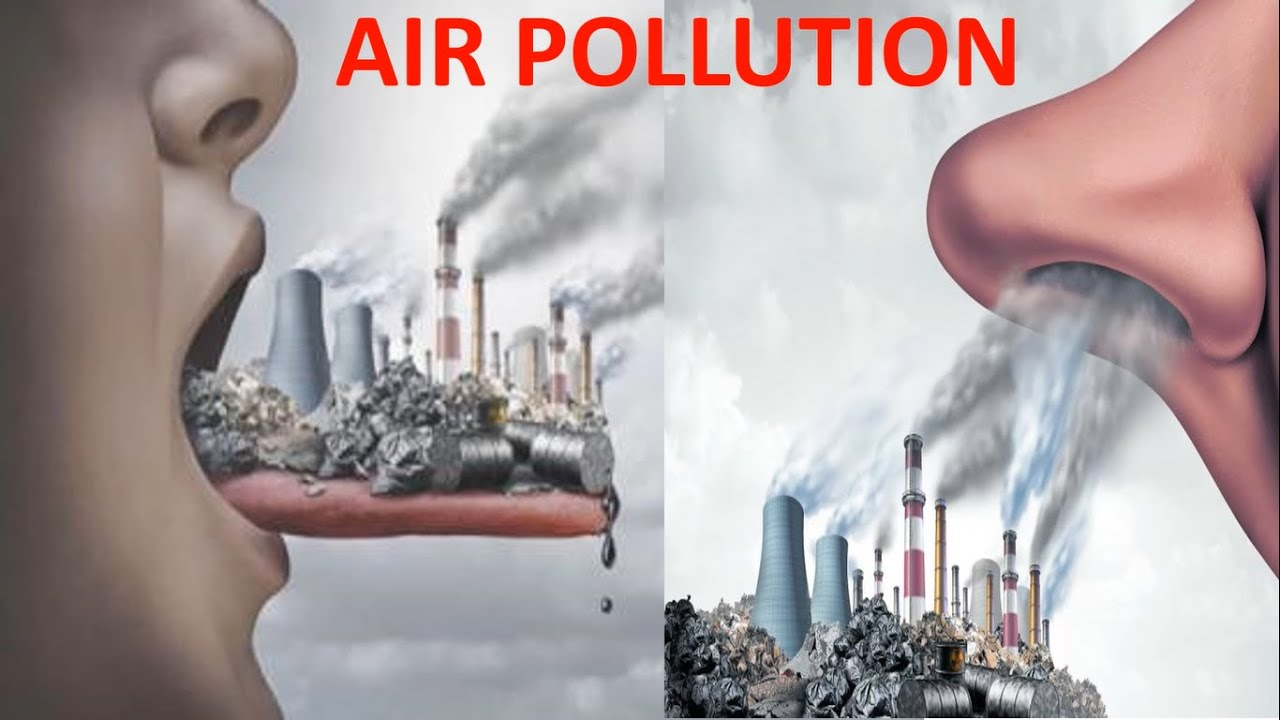

## Contents
1. [INTRODUCTION](#1.-Introduction)
       
      1.1 [Scope](#1.1-Scope)
      
      1.2 [Business_Problem](#1.2-Business_Problem)
      
      1.3 [Required_Libraries](#1.3-Required_Libraries)
      
      1.4 [load_the_data](#1.4-load_the_data)
      
      1.5 [Data_Library](#1.5-Data_Library)
      
      1.6 [Granger_Casuality_test](#1.6-Granger_Casuality_test)
      
      1.7 [Cointegration _est](#1.7-Cointegration_Test)
      
      1.8 [Train_test_split](#1.8-Train_test_split)
      
      
2. [ VAR_model](#2.-VAR_model)

     2.1 [Model_Forecasting](#2.1-Model_Forecasting)
     
     2.2 [Manual_calculation_for_forecasting](#2.2-Manual_calculation_for_forecasting)
     
     2.3 [Visualization_of_Actual_and_Predicted](#2.3-Visualization_of_Actual_and_Predicted)
     
     2.4 [Mean_Absolute_Percentage_Error](#2.4-Mean_Absolute_Percentage_Error)
      
      
3.[Lstm_Model](#3.-Lstm_Model)

   3.1 [Model_Building](#3.1-Model_Building)

# 1. INTRODUCTION

In This Notebook we will see how we will forecast the pollution level in the air using Multivariate Time Series Data.

# 1.1 Scope

Poor air quality has harmful effects on human health, particularly the respiratory and cardiovascular systems. Pollutants can also damage plants and buildings, and smoke or haze can reduce visibility.

# 1.2 Business_Problem

Air pollution is bad for business. Around 1.2 billion workdays are lost globally each year due to air pollution, which could reach 3.8 billion days by 2060.  

Employees breathing polluted air are much more likely to get sick and experience reduced cognitive performance.

# 1.3 Required_Libraries

In [1]:
#!pip install tensorflow

In [76]:
# import 'Pandas'  # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd 

# import 'Numpy' # linear algebra
import numpy as np

# import subpackage of Matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# import 'Seaborn' 
import seaborn as sns

# import various functions from statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from scipy.stats import jarque_bera

# import various functions from sklearn 

from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler

# import various functions from tensorflow

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

# to suppress warnings 
from warnings import filterwarnings
filterwarnings('ignore')
from array import array

from statsmodels.stats.diagnostic import het_arch



# 1.4 load_the_data

In [3]:
df = pd.read_csv('LSTM-Multivariate_pollution.csv',parse_dates=True,squeeze=True,index_col=0)
df.head(5)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


# 1.5 Data_Library

In [4]:
data_library = {'pollution': 'pollution level',
                'dew'      : 'Dew Point',
                'temp'     : 'Temperature',
                 'pres'    : 'Pressure',
                'wnd_dir'  : 'Wind direction',
                'wnd_spd'  : 'Wind Speed',
                'snow'     : 'cumulative hours of snow',
                'rain'     : 'cumulated hours of rain'}

In [5]:
from sklearn.preprocessing import LabelEncoder
# Initialize the label encoder
le = LabelEncoder()

# Fit and transform the data
df['wnd_dir'] = le.fit_transform(df['wnd_dir'])

In [7]:
df.tail(10)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2014-12-31 14:00:00,9.0,-27,1.0,1032.0,1,196.21,0,0
2014-12-31 15:00:00,11.0,-26,1.0,1032.0,1,205.15,0,0
2014-12-31 16:00:00,8.0,-23,0.0,1032.0,1,214.09,0,0
2014-12-31 17:00:00,9.0,-22,-1.0,1033.0,1,221.24,0,0
2014-12-31 18:00:00,10.0,-22,-2.0,1033.0,1,226.16,0,0
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,1,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,1,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,1,242.70,0,0
2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,1,246.72,0,0


# Instead of using parse dates function in Pandas we can use this way also to make Time index

In [8]:
date = pd.date_range(start='2010-01-31 00:00:00', end='2014-12-31 23:00:00')

In [10]:
df.describe()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,1.663516,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,0.938032,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,2.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,2.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,3.000000,585.600000,27.000000,36.000000


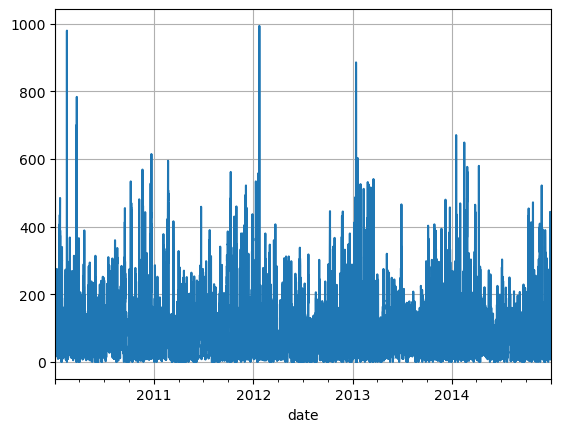

In [11]:
df['pollution'].plot();
plt.grid()

In [12]:
from sklearn.preprocessing import LabelEncoder
# Initialize the label encoder
le = LabelEncoder()

# Fit and transform the data
df['wnd_dir'] = le.fit_transform(df['wnd_dir'])

# 1.6 Granger_Casuality_test

In [12]:
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

In [13]:
def granular_casuality_test(df):
    for var1 in df.columns:
        for var2 in df.columns:
            if var1 != var2:
            # Perform the Granger causality test
                gc_res = grangercausalitytests(np.vstack([df[var1], df[var2]]).T, maxlag=1, verbose=False)# Extract the p-value from the Granger causality test results
                p_value = gc_res[1][0]['ssr_ftest'][1]

            # Determine whether there is a causal relationship between var1 and var2
                if p_value < 0.05:
                    print("There is a causal relationship between {} and {}.".format(var1, var2))
                else:
                    print("There is no causal relationship between {} and {}.".format(var1, var2))
                
            # printing the variables name
                
                if p_value < 0.05:
                    print('Casual relationship variables:', var1, var2)
                else:
                    print('No releationship variables:', var1, var2)

In [14]:
granular_casuality_test(df)

There is a causal relationship between pollution and dew.
Casual relationship variables: pollution dew
There is a causal relationship between pollution and temp.
Casual relationship variables: pollution temp
There is no causal relationship between pollution and press.
No releationship variables: pollution press
There is a causal relationship between pollution and wnd_dir.
Casual relationship variables: pollution wnd_dir
There is a causal relationship between pollution and wnd_spd.
Casual relationship variables: pollution wnd_spd
There is no causal relationship between pollution and snow.
No releationship variables: pollution snow
There is a causal relationship between pollution and rain.
Casual relationship variables: pollution rain
There is no causal relationship between dew and pollution.
No releationship variables: dew pollution
There is a causal relationship between dew and temp.
Casual relationship variables: dew temp
There is a causal relationship between dew and press.
Casual re

In [15]:
for var1 in df.columns:
        for var2 in df.columns:
            if var1 != var2:
            # Perform the Granger causality test
                gc_res = grangercausalitytests(np.vstack([df[var1], df[var2]]).T, maxlag=1, verbose=False)# Extract the p-value from the Granger causality test results
                p_value = gc_res[1][0]['ssr_ftest'][1]
                
                # printing the variables name
                
                if p_value < 0.05:
                    print('Casual relationship variables:', var1, var2)
                    break  

Casual relationship variables: pollution dew
Casual relationship variables: dew temp
Casual relationship variables: temp pollution
Casual relationship variables: press pollution
Casual relationship variables: wnd_dir pollution
Casual relationship variables: wnd_spd pollution
Casual relationship variables: snow temp
Casual relationship variables: rain dew


# 1.7 Cointegration_Test

In [20]:
import statsmodels.api as sm

In [17]:
def cointegration_test(df):
    for var1 in df.columns:
        for var2 in df.columns:
            if var1 != var2:
            # Perform the cointegration test
                coint_res =  sm.tsa.stattools.coint(df[var1], df[var2])

            # Extract the p-value from the cointegration test results
                p_value = coint_res[1]

            # Determine whether there is a cointegrating relationship between var1 and var2
                if p_value < 0.05:
                    print("There is a cointegrating relationship between {} and {}.".format(var1, var2))
                else:
                    print("There is no cointegrating relationship between {} and {}.".format(var1, var2))

In [18]:
print(cointegration_test(df))

There is a cointegrating relationship between pollution and dew.
There is a cointegrating relationship between pollution and temp.
There is a cointegrating relationship between pollution and press.
There is a cointegrating relationship between pollution and wnd_dir.
There is a cointegrating relationship between pollution and wnd_spd.
There is a cointegrating relationship between pollution and snow.
There is a cointegrating relationship between pollution and rain.
There is a cointegrating relationship between dew and pollution.
There is a cointegrating relationship between dew and temp.
There is a cointegrating relationship between dew and press.
There is a cointegrating relationship between dew and wnd_dir.
There is a cointegrating relationship between dew and wnd_spd.
There is a cointegrating relationship between dew and snow.
There is a cointegrating relationship between dew and rain.
There is a cointegrating relationship between temp and pollution.
There is a cointegrating relations

In [19]:
for var1 in df.columns:
        for var2 in df.columns:
            if var1 != var2:
                # Perform the cointegration test
                coint_res =  sm.tsa.stattools.coint(df[var1], df[var2])

            # Extract the p-value from the cointegration test results
                p_value = coint_res[1]

            # Determine whether there is a cointegrating relationship between var1 and var2
            # printing the variables name
                if p_value < 0.05:
                    print('Significant variables:', var1, var2 )
                    break

Significant variables: pollution dew
Significant variables: dew pollution
Significant variables: temp pollution
Significant variables: press pollution
Significant variables: wnd_dir pollution
Significant variables: wnd_spd pollution
Significant variables: snow pollution
Significant variables: rain pollution


In [13]:
df = df.drop(['temp', 'snow', 'rain', 'wnd_spd'], axis = 1)

In [14]:
df.head()

,pollution,dew,press,wnd_dir
date,,,,
2010-01-02 00:00:00,129.0,-16,1020.0,2
2010-01-02 01:00:00,148.0,-15,1020.0,2
2010-01-02 02:00:00,159.0,-11,1021.0,2
2010-01-02 03:00:00,181.0,-7,1022.0,2
2010-01-02 04:00:00,138.0,-7,1022.0,2


# 1.8 Train_test_split

In [15]:
size = int(len(df) * 0.90)
train, test = df[0:size], df[size:len(df)]
print('Train Shape',train.shape)
print('Test Shape', test.shape)

Train Shape (39420, 4)
Test Shape (4380, 4)


In [16]:
train.tail()

,pollution,dew,press,wnd_dir
date,,,,
2014-07-02 07:00:00,58.0,20,1004.0,2
2014-07-02 08:00:00,57.0,20,1004.0,3
2014-07-02 09:00:00,52.0,21,1004.0,2
2014-07-02 10:00:00,33.0,21,1004.0,3
2014-07-02 11:00:00,50.0,21,1004.0,2


In [17]:
test.head()

,pollution,dew,press,wnd_dir
date,,,,
2014-07-02 12:00:00,56.0,21,1003.0,2
2014-07-02 13:00:00,64.0,21,1003.0,3
2014-07-02 14:00:00,66.0,21,1002.0,3
2014-07-02 15:00:00,72.0,21,1002.0,3
2014-07-02 16:00:00,78.0,21,1002.0,3


# 2. VAR_model 

In [18]:
import statsmodels.api as sm
model = VAR(train)
for i in range(4):
    result = model.fit(i)   # More the lag more the problem
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)

Lag Order = 0
AIC :  17.883146661352516
BIC :  17.884017491244013
Lag Order = 1
AIC :  6.165178327126887
BIC :  6.169532574171486
Lag Order = 2
AIC :  6.030115610038099
BIC :  6.037953430383501
Lag Order = 3
AIC :  5.94183329788627
BIC :  5.953154847691281


In [19]:
model.select_order(4).summary()

,AIC,BIC,FPE,HQIC
0,17.88,17.88,5.843e+07,17.88
1,6.165,6.169,475.8,6.166
2,6.030,6.038,415.7,6.032
3,5.942,5.953,380.6,5.945
4,5.927*,5.942*,375.1*,5.932*


In [20]:
result1 = model.fit(4)

In [21]:
print(result1.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 18, Mar, 2023
Time:                     10:44:51
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    5.94208
Nobs:                     39416.0    HQIC:                   5.93196
Log likelihood:          -340462.    FPE:                    375.130
AIC:                      5.92727    Det(Omega_mle):         374.483
--------------------------------------------------------------------
Results for equation pollution
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const              -45.031803        21.985056           -2.048           0.041
L1.pollution         0.931727         0.005065          183.956           0.000
L1.dew               2.117482         0.102345           20.

In [22]:
test.shape

(4380, 4)

# 2.1 Model_Forecasting

In [23]:
lag = result1.k_ar # the function K_ar gives the lag taken by the model

In [24]:
lag

4

In [25]:
predi = result1.forecast(train.values[-4:],steps=6) # here i am predicting the first 5 values of the test dataset

In [26]:
predi= pd.DataFrame(predi)
predi.head()

,0,1,2,3
0,56.208655,21.085112,1004.013018,2.141252
1,59.665437,21.089849,1004.012275,2.043987
2,63.496905,21.128576,1004.012821,2.037239
3,66.055423,21.107795,1004.010162,1.971067
4,68.364653,21.080941,1004.010234,1.952571


In [27]:
Predicted_values = predi[0]
Predicted_values

0    56.208655
1    59.665437
2    63.496905
3    66.055423
4    68.364653
5    70.247421
Name: 0, dtype: float64

In [28]:
test.head()

,pollution,dew,press,wnd_dir
date,,,,
2014-07-02 12:00:00,56.0,21,1003.0,2
2014-07-02 13:00:00,64.0,21,1003.0,3
2014-07-02 14:00:00,66.0,21,1002.0,3
2014-07-02 15:00:00,72.0,21,1002.0,3
2014-07-02 16:00:00,78.0,21,1002.0,3


In [29]:
Actual_values = test['pollution'].head(6)
Actual_values = pd.DataFrame(Actual_values.values)
Actual_values

,0
0,56.0
1,64.0
2,66.0
3,72.0
4,78.0
5,78.0


In [30]:
results = pd.DataFrame()
results['Actual']= Actual_values
results['Predicted'] = Predicted_values
results['Errors'] = results['Actual'] - results['Predicted']
results.head()

,Actual,Predicted,Errors
0,56.0,56.208655,-0.208655
1,64.0,59.665437,4.334563
2,66.0,63.496905,2.503095
3,72.0,66.055423,5.944577
4,78.0,68.364653,9.635347


In [31]:
train.head()

,pollution,dew,press,wnd_dir
date,,,,
2010-01-02 00:00:00,129.0,-16,1020.0,2
2010-01-02 01:00:00,148.0,-15,1020.0,2
2010-01-02 02:00:00,159.0,-11,1021.0,2
2010-01-02 03:00:00,181.0,-7,1022.0,2
2010-01-02 04:00:00,138.0,-7,1022.0,2


In [32]:
training_errors = pd.DataFrame(result1.resid['pollution'].values)
training_errors.head()

,0
0,-52.629656
1,-34.790485
2,-7.463020
3,17.356998
4,-3.848978


In [33]:
results['training_errors']= training_errors
results

,Actual,Predicted,Errors,training_errors
0,56.0,56.208655,-0.208655,-52.629656
1,64.0,59.665437,4.334563,-34.790485
2,66.0,63.496905,2.503095,-7.463020
3,72.0,66.055423,5.944577,17.356998
4,78.0,68.364653,9.635347,-3.848978
5,78.0,70.247421,7.752579,13.894039


In [34]:
Y_actual = results['Actual']
Y_Predicted = results['Predicted']

In [35]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(Y_actual,Y_Predicted)

0.06914415391066565

# visualization of Model performance using training actuals and predicted values

In [36]:
training_results = train.iloc[4:,[0]]
training_results['forecasted'] = result1.fittedvalues['pollution']
training_results['resid'] = result1.resid['pollution']


In [37]:
training_results.head()

,pollution,forecasted,resid
date,,,
2010-01-02 04:00:00,138.0,190.629656,-52.629656
2010-01-02 05:00:00,109.0,143.790485,-34.790485
2010-01-02 06:00:00,105.0,112.463020,-7.463020
2010-01-02 07:00:00,124.0,106.643002,17.356998
2010-01-02 08:00:00,120.0,123.848978,-3.848978


<AxesSubplot:xlabel='date'>

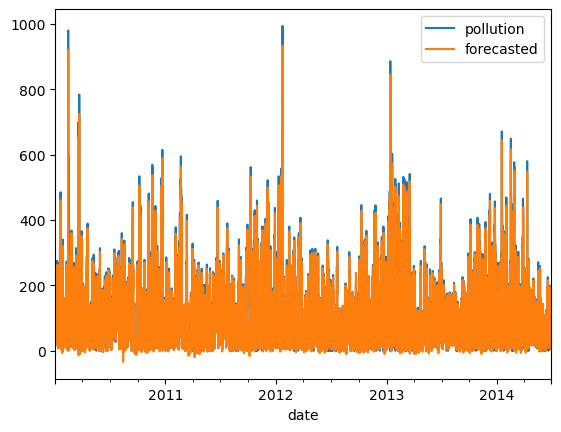

In [38]:
training_results.iloc[:-100,[0,1]].plot()

<AxesSubplot:xlabel='date'>

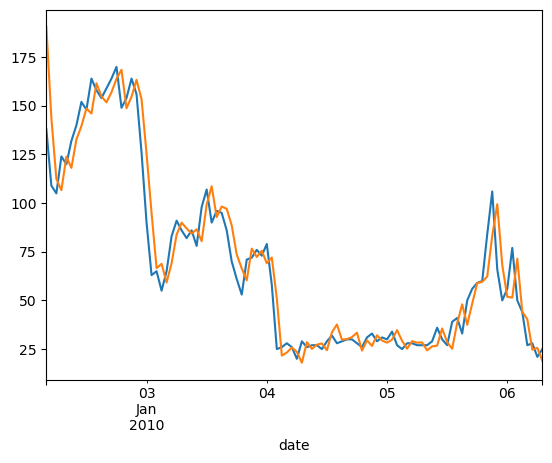

In [39]:
training_results.pollution.head(100).plot()
training_results.forecasted.head(100).plot()

# Heteroscedasticity test

# Perform the ARCH LM test for heteroscedasticity

In [59]:
residuals = training_results['resid'].values

In [60]:
test_result = het_arch(residuals)

# Print the test statistic and p-value
print("Test statistic: ", test_result[0])
print("P-value: ", test_result[1])

# Set the significance level
alpha = 0.05

# Compare the p-value to the significance level
if test_result[1] < alpha:
    print("Reject null hypothesis: There is evidence of heteroscedasticity.")
else:
    print("Accept null hypothesis: There is no evidence of heteroscedasticity.")

Test statistic:  7715.772799044258
P-value:  0.0
Reject null hypothesis: There is evidence of heteroscedasticity.


# Normality Test

# jarque_bera test

In [77]:
# Perform the Jarque-Bera test for normality
test_result = jarque_bera(residuals)

# Print the test statistic and p-value
print("Test statistic: ", test_result[0])
print("P-value: ", test_result[1])

# Set the significance level
alpha = 0.05

# Compare the p-value to the significance level
if test_result[1] < alpha:
    print("Reject null hypothesis: The residuals are not normally distributed.")
else:
    print("Accept null hypothesis: The residuals are normally distributed.")

Test statistic:  22200345.69201581
P-value:  0.0
Reject null hypothesis: The residuals are not normally distributed.


# 2.2 Manual_calculation_for_forecasting

In [39]:
# Our target column is Pollution so we are taking pollution column alone to predict

In [40]:
df_coeff = pd.DataFrame([result1.params['pollution'], result1.pvalues['pollution']]).T

In [41]:
# params is nothing but coefficients of the variables and pvalues are corresponding probability values

In [42]:
df_coeff

,pollution,pollution
const,-45.031803,4.053145e-02
L1.pollution,0.931727,0.000000e+00
L1.dew,2.117482,4.296548e-95
L1.press,-0.059345,7.813625e-01
L1.wnd_dir,1.440390,1.870656e-17
L2.pollution,0.008892,1.979228e-01
L2.dew,-1.064433,2.478301e-13
L2.press,-0.256473,4.318084e-01
L2.wnd_dir,1.738870,2.239452e-23
L3.pollution,-0.001125,8.704909e-01


In [43]:
df_coeff.columns= ['Coefficients', 'P-values']  # renaming the data frame

In [44]:
df_coeff

,Coefficients,P-values
const,-45.031803,4.053145e-02
L1.pollution,0.931727,0.000000e+00
L1.dew,2.117482,4.296548e-95
L1.press,-0.059345,7.813625e-01
L1.wnd_dir,1.440390,1.870656e-17
L2.pollution,0.008892,1.979228e-01
L2.dew,-1.064433,2.478301e-13
L2.press,-0.256473,4.318084e-01
L2.wnd_dir,1.738870,2.239452e-23
L3.pollution,-0.001125,8.704909e-01


In [45]:
# df_coeff.query('P-values < 0.05')
np.where(df_coeff['P-values'] < 0.05,1,0)  # taking p -value is 0.05 below this value all the variables are significant so I marked as "1"

array([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [46]:
df_coeff['valid']= np.where(df_coeff['P-values'] < 0.05,1,0)

In [47]:
df_coeff

,Coefficients,P-values,valid
const,-45.031803,4.053145e-02,1
L1.pollution,0.931727,0.000000e+00,1
L1.dew,2.117482,4.296548e-95,1
L1.press,-0.059345,7.813625e-01,0
L1.wnd_dir,1.440390,1.870656e-17,1
L2.pollution,0.008892,1.979228e-01,0
L2.dew,-1.064433,2.478301e-13,1
L2.press,-0.256473,4.318084e-01,0
L2.wnd_dir,1.738870,2.239452e-23,1
L3.pollution,-0.001125,8.704909e-01,0


In [48]:
coeff_arr = df_coeff['Coefficients'][1:].values

In [49]:
# Taking all the coefficients over here and taking values out of it like the linear equation 



In [50]:
coeff_arr.shape  # Reason for 8 is * features 1 lags

(16,)

In [51]:
train.values[-lag:]

array([[  57.,   20., 1004.,    3.],
       [  52.,   21., 1004.,    2.],
       [  33.,   21., 1004.,    3.],
       [  50.,   21., 1004.,    2.]])

In [52]:
in_arr = train[-lag:][::-1].stack().to_frame().T.values  # Transposing the values into the single row and make it array 

In [53]:
in_arr.shape

(1, 16)

In [54]:
in_arr

array([[  50.,   21., 1004.,    2.,   33.,   21., 1004.,    3.,   52.,
          21., 1004.,    2.,   57.,   20., 1004.,    3.]])

In [55]:
np.dot(in_arr, coeff_arr) + df_coeff['Coefficients'][:1].values
# To take the coefficients and multiply with the input values and add the constant

array([56.20865542])

In [56]:
test

,pollution,dew,press,wnd_dir
date,,,,
2014-07-02 12:00:00,56.0,21,1003.0,2
2014-07-02 13:00:00,64.0,21,1003.0,3
2014-07-02 14:00:00,66.0,21,1002.0,3
2014-07-02 15:00:00,72.0,21,1002.0,3
2014-07-02 16:00:00,78.0,21,1002.0,3
...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,1034.0,1
2014-12-31 20:00:00,10.0,-22,1034.0,1
2014-12-31 21:00:00,10.0,-22,1034.0,1


# 2.3 Visualization_of_Actual_and_Predicted 

In [78]:
results

,Actual,Predicted,Errors,training_errors
0,56.0,56.208655,-0.208655,-52.629656
1,64.0,59.665437,4.334563,-34.790485
2,66.0,63.496905,2.503095,-7.463020
3,72.0,66.055423,5.944577,17.356998
4,78.0,68.364653,9.635347,-3.848978
5,78.0,70.247421,7.752579,13.894039


<AxesSubplot:>

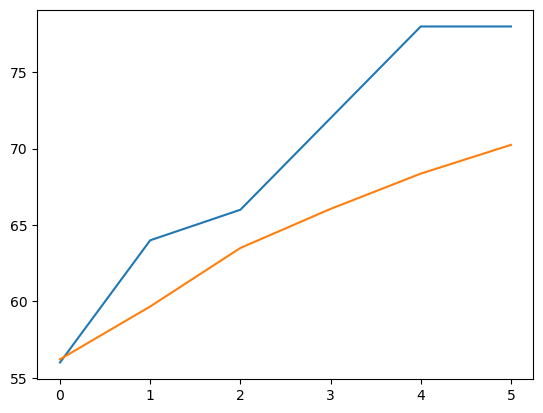

In [79]:
results['Actual'].head(100).plot()
results['Predicted'].head(100).plot()

# 2.4 Mean_Absolute_Percentage_Error

In [80]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(Y_actual,Y_Predicted)

0.06914415391066565

In [81]:
# User Defined Functions for MAPE functions
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return round(mape,2)

In [82]:
Y_actual

0    56.0
1    64.0
2    66.0
3    72.0
4    78.0
5    78.0
Name: Actual, dtype: float64

In [83]:
Y_Predicted

0    56.208655
1    59.665437
2    63.496905
3    66.055423
4    68.364653
5    70.247421
Name: Predicted, dtype: float64

In [84]:
Y_actual = results['Actual']
Y_Predicted = results['Predicted']
MAPE(Y_actual,Y_Predicted)

6.91

# VAR MODEL captures linearity in the data. To capture non-linearity we are trying to build a LSTM MODEL by giving the errors.

# 3. Lstm_Model 

In [123]:
training_results.head()

,pollution,forecasted,resid
date,,,
2010-01-02 04:00:00,138.0,190.629656,-52.629656
2010-01-02 05:00:00,109.0,143.790485,-34.790485
2010-01-02 06:00:00,105.0,112.463020,-7.463020
2010-01-02 07:00:00,124.0,106.643002,17.356998
2010-01-02 08:00:00,120.0,123.848978,-3.848978


In [124]:
data = pd.DataFrame(training_results['resid'].values)
data.head()

,0
0,-52.629656
1,-34.790485
2,-7.463020
3,17.356998
4,-3.848978


In [125]:
data.shape

(39416, 1)

In [126]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [127]:
# scaling the data
scaler =  MinMaxScaler()
scaler.fit(data)

scaled_data = scaler.transform(data)

In [128]:
#choose a number of time steps
look_back = 4
# choose a time series data
timeseries_data = scaled_data

In [129]:
# Create function to prepare data for LSTM model
def prepare_data(data, look_back):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        Y.append(data[(i+look_back), 0])
    return np.array(X), np.array(Y)


In [130]:
X, y = prepare_data(timeseries_data, look_back)

In [131]:
print(X), print(y)

[[0.51264508 0.52316606 0.53928294 0.553921  ]
 [0.52316606 0.53928294 0.553921   0.54141438]
 [0.53928294 0.553921   0.54141438 0.55187865]
 ...
 [0.54577053 0.55453556 0.54025387 0.54357921]
 [0.55453556 0.54025387 0.54357921 0.54139426]
 [0.54025387 0.54357921 0.54139426 0.53888748]]
[0.54141438 0.55187865 0.54799343 ... 0.54139426 0.53888748 0.52839557]


(None, None)

In [132]:
X.shape # this gives a records count with a time steps

(39411, 4)

In [133]:
y.shape # this is the output or dependent variable

(39411,)

In [134]:
# reshape from [samples, timesteps] into [samples,timesteps, features]
# just converting 2d into 3 dimensional for lstm input by adding 1 because here it is univariate
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [135]:
X.shape  # now it is 2 dimensional 

(39411, 4, 1)

MOdel

In [136]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(look_back, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics = 'mean_absolute_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [173]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='mean_absolute_error', patience=4)

In [174]:
# fit model
model_fit = model.fit(X, y, epochs=10, verbose=1, shuffle = False,callbacks=[early_stop])

Epoch 1/10
1232/1232 [==============================] - 81s 66ms/step - loss: 0.0058 - mean_absolute_error: 0.0220
Epoch 2/10
1232/1232 [==============================] - 90s 73ms/step - loss: 2.7804e-04 - mean_absolute_error: 0.0085
Epoch 3/10
1232/1232 [==============================] - 87s 71ms/step - loss: 2.7831e-04 - mean_absolute_error: 0.0086
Epoch 4/10
1232/1232 [==============================] - 85s 69ms/step - loss: 2.7950e-04 - mean_absolute_error: 0.0087
Epoch 5/10
1232/1232 [==============================] - 88s 71ms/step - loss: 2.7878e-04 - mean_absolute_error: 0.0088
Epoch 6/10
1232/1232 [==============================] - 90s 73ms/step - loss: 2.7766e-04 - mean_absolute_error: 0.0088


In [176]:
model.save(r"C:\Users\BIS\Desktop\model_save\model_lstm_air_pollution1.h5")

In [177]:
import keras

In [178]:
model1 = keras.models.load_model(r"C:\Users\BIS\Desktop\model_save\model_lstm_air_pollution1.h5")

# Predicting for the next 6 data

In [201]:
scaled_data

array([[0.51264508],
       [0.52316606],
       [0.53928294],
       ...,
       [0.53888748],
       [0.52839557],
       [0.54946981]])

In [202]:
# demonstrate prediction for next 6 hours
x_input = scaled_data[-5:]
temp_input = x_input
forecasted_output = []
i = 0
while i < 6:
    if len(temp_input) > 3:
        x_input = temp_input[1:]
        print("{} hour input {}".format(i, x_input))
        x_input = x_input.reshape((1, 4, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} hour output {}".format(i, yhat))
        temp_input = np.concatenate((temp_input, yhat), axis=0)[1:]
        forecasted_output.append(yhat[0][0])
        i += 1
    else:
        x_input = x_input.reshape((1, 4, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} hour output {}".format(i, yhat))
        temp_input = np.concatenate((temp_input, yhat), axis=0)
        forecasted_output.append(yhat[0][0])
        i += 1

print(forecasted_output)

0 hour input [[0.54139426]
 [0.53888748]
 [0.52839557]
 [0.54946981]]
0 hour output [[0.5407524]]
1 hour input [[0.53888748]
 [0.52839557]
 [0.54946981]
 [0.54075241]]
1 hour output [[0.54069686]]
2 hour input [[0.52839557]
 [0.54946981]
 [0.54075241]
 [0.54069686]]
2 hour output [[0.5407931]]
3 hour input [[0.54946981]
 [0.54075241]
 [0.54069686]
 [0.54079312]]
3 hour output [[0.5415874]]
4 hour input [[0.54075241]
 [0.54069686]
 [0.54079312]
 [0.54158741]]
4 hour output [[0.5411005]]
5 hour input [[0.54069686]
 [0.54079312]
 [0.54158741]
 [0.5411005 ]]
5 hour output [[0.54112136]]
[0.5407524, 0.54069686, 0.5407931, 0.5415874, 0.5411005, 0.54112136]


In [203]:
forecasted_output

[0.5407524, 0.54069686, 0.5407931, 0.5415874, 0.5411005, 0.54112136]

# These are the results from VAR MODEL

In [205]:
results # These are the results from VAR MODEL

,Actual,Predicted,Errors,training_errors
0,56.0,56.208655,-0.208655,-52.629656
1,64.0,59.665437,4.334563,-34.790485
2,66.0,63.496905,2.503095,-7.463020
3,72.0,66.055423,5.944577,17.356998
4,78.0,68.364653,9.635347,-3.848978
5,78.0,70.247421,7.752579,13.894039


# These are the results from LSTM Model

In [207]:
forecasted_output # These are the results from LSTM Model

[0.5407524, 0.54069686, 0.5407931, 0.5415874, 0.5411005, 0.54112136]

# Combine the results from VAR model and LSTM Model

In [212]:
final_forecast = results['Predicted'].values + forecasted_output
final_forecast

array([56.74940783, 60.20613362, 64.03769848, 66.5970106 , 68.90575302,
       70.78854193])

In [215]:
# Because we build a LSTM Model on top of residuals (unwxplained Variance)
df_final = pd.DataFrame(final_forecast.T, columns=['forecast'])
df_final

,forecast
0,56.749408
1,60.206134
2,64.037698
3,66.597011
4,68.905753
5,70.788542


# Visualizations

# to show the LSTM model performance

1232/1232 [==============================] - 34s 28ms/step


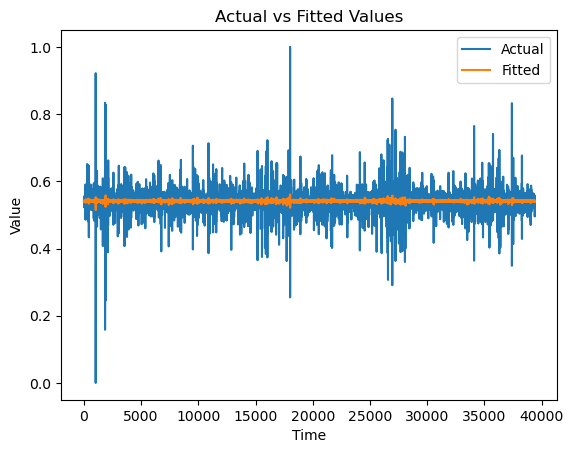

In [217]:
# generate fitted values
y_fitted = model.predict(X)

# compare the fitted values to the actual values
plt.plot(y, label='Actual')
plt.plot(y_fitted, label='Fitted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Fitted Values')
plt.show()


In [219]:
# calculate MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y, y_fitted)
print('Mean Absoulte Error:', mae)

Mean Absoulte Error: 0.00835441518219773


In [163]:
import matplotlib.pyplot as plt


In [164]:
df_final.head()

,forecast
0,56.210868
1,59.667071
2,63.497807
3,66.055779
4,68.364656


In [165]:
present_values = results['Actual']
present_values

0    56.0
1    64.0
2    66.0
3    72.0
4    78.0
5    78.0
Name: Actual, dtype: float64

# visualization of final forecasted value (VAR + LSTM)

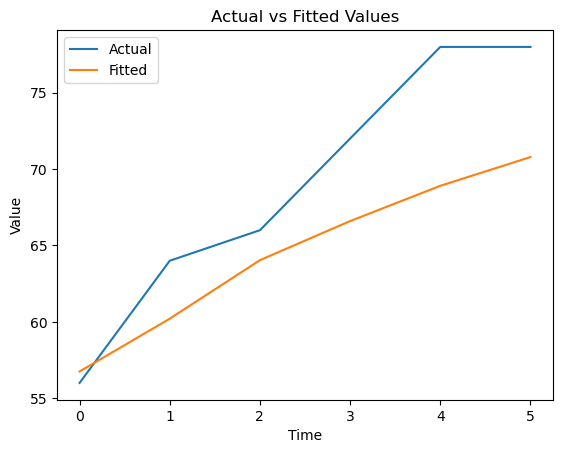

In [214]:
plt.plot(present_values,label= 'Actual' )
plt.plot(df_final.values, label = 'Fitted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Fitted Values')
plt.show()

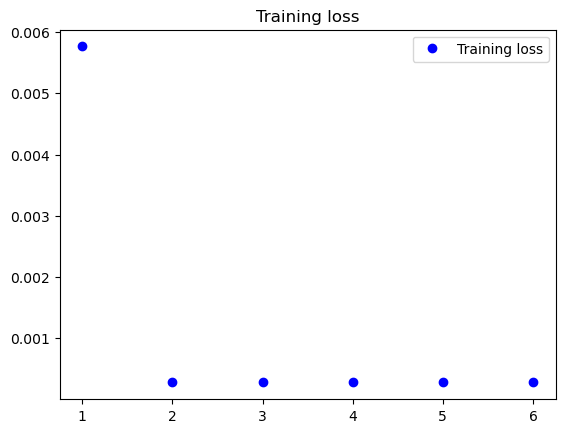

In [220]:
import matplotlib.pyplot as plt
loss = model_fit.history['loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

# To find the future pollution level

In [221]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [222]:
test1 = test['pollution']
test1

date
2014-07-02 12:00:00    56.0
2014-07-02 13:00:00    64.0
2014-07-02 14:00:00    66.0
2014-07-02 15:00:00    72.0
2014-07-02 16:00:00    78.0
                       ... 
2014-12-31 19:00:00     8.0
2014-12-31 20:00:00    10.0
2014-12-31 21:00:00    10.0
2014-12-31 22:00:00     8.0
2014-12-31 23:00:00    12.0
Name: pollution, Length: 4380, dtype: float64

In [295]:
# demonstrate prediction for next 6 hours
x_input = test1[-5:]
temp_input = x_input
forecasted_output = []
i = 0
while i < 6:
    if len(temp_input) > 3:
        x_input = temp_input[1:]
        print("{} hour input {}".format(i, x_input))
        x_input = np.array(x_input).reshape((1, 4, 1))
        yhat = model1.predict(x_input, verbose=0)
        print("{} hour output {}".format(i, yhat))
        temp_input = np.concatenate((temp_input, yhat[0]), axis=0)[1:]
        forecasted_output.append(yhat[0][0])
        i += 1
    else:
        x_input = np.array(x_input).reshape((1, 4, 1))
        yhat = model1.predict(x_input, verbose=0)
        print("{} hour output {}".format(i, yhat))
        temp_input = np.concatenate((temp_input, yhat[0]), axis=0)
        forecasted_output.append(yhat[0][0])
        i += 1

print(forecasted_output)

0 hour input date
2014-12-31 20:00:00    10.0
2014-12-31 21:00:00    10.0
2014-12-31 22:00:00     8.0
2014-12-31 23:00:00    12.0
Name: pollution, dtype: float64
0 hour output [[1.4839656]]
1 hour input [10.          8.         12.          1.48396564]
1 hour output [[1.5439031]]
2 hour input [ 8.         12.          1.48396564  1.54390311]
2 hour output [[1.4088485]]
3 hour input [12.          1.48396564  1.54390311  1.40884852]
3 hour output [[1.2447314]]
4 hour input [1.48396564 1.54390311 1.40884852 1.24473143]
4 hour output [[0.6855717]]
5 hour input [1.54390311 1.40884852 1.24473143 0.68557167]
5 hour output [[0.66725624]]
[1.4839656, 1.5439031, 1.4088485, 1.2447314, 0.6855717, 0.66725624]


In [302]:
future_forecast = pd.DataFrame()
future_forecast['values']= forecasted_output

In [303]:
future_forecast

,values
0,1.483966
1,1.543903
2,1.408849
3,1.244731
4,0.685572
5,0.667256


<AxesSubplot:>

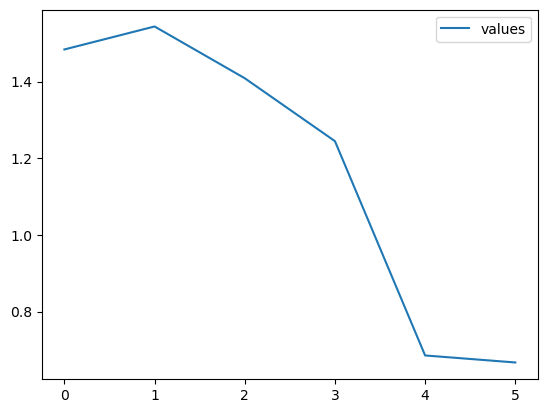

In [304]:
future_forecast.plot()